# Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).
Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs.

In [6]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
from sklearn.utils import Bunch


digits = sklearn.datasets.load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [8]:
x: np.ndarray = digits.data
y: np.ndarray = digits.target
print(x.shape, y.shape)

(1797, 64) (1797,)


### Шаг 1
Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score.

In [9]:
decision_tree_classifier = DecisionTreeClassifier()
cross_val_score(decision_tree_classifier, x, y, cv=10).mean()

np.float64(0.8285630043451272)

### Шаг 2

Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

In [10]:
bagging_classifier = BaggingClassifier(decision_tree_classifier, n_estimators=100)
bagging_classifier.fit(x, y);
cross_val_score(bagging_classifier, x, y, cv=10).mean()

np.float64(0.9253848541278709)

### Шаг 3
Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [11]:
bagging_classifier = BaggingClassifier(
    decision_tree_classifier, n_estimators=100, max_features=int(x.shape[1] ** 0.5)
)
cross_val_score(bagging_classifier, x, y, cv=10).mean()

np.float64(0.936002482929857)

### Шаг 4
Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$ признаков.

In [12]:
decision_tree_classifier = DecisionTreeClassifier(max_features='sqrt')
bagging_classifier = BaggingClassifier(decision_tree_classifier, n_estimators=100)
cross_val_score(bagging_classifier, x, y, cv=10).mean()

np.float64(0.9521322160148975)

### Шаг 5

Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности постройте графики зависимости качества от значений параметров.

На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера

  1. Случайный лес сильно переобучается с ростом количества деревьев
  2. При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев
  3. С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.
  4. При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.
  5. При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.
  6. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.
  7. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

In [18]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, max_features='sqrt')
cross_val_score(random_forest_classifier, x, y, cv=10).mean()

np.float64(0.9487988826815641)

#### Зависимость от количества деревьев

In [ ]:
# long computation ~ 1 min

trees_ns = [5, 10, 15, 40, 100, 200, 400, 800, 1600]
trees_scores = []
for n in trees_ns:
    random_forest_classifier = RandomForestClassifier(n_estimators=n, max_features='sqrt', n_jobs=-1)
    score = cross_val_score(random_forest_classifier, x, y, cv=10)
    trees_scores.append(score)

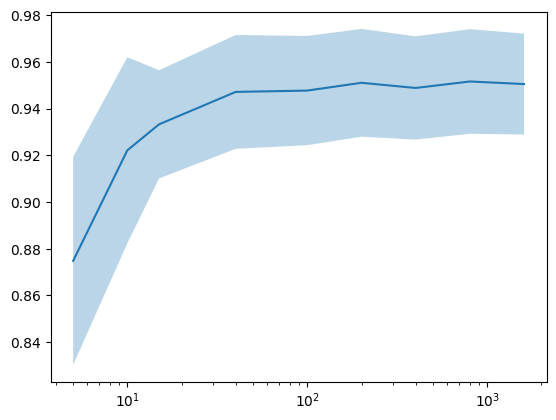

In [20]:
plt.plot(trees_ns, [s.mean() for s in trees_scores])
plt.fill_between(
    trees_ns,
    [np.mean(s) - np.std(s) for s in trees_scores],
    [np.mean(s) + np.std(s) for s in trees_scores],
    alpha=0.3,
)
plt.xscale('log')

С ростом количества деревьев оценка только увеличивается, значит переобучения не происходит, наоборот, меньше деревьев показывают результат хуже

#### Зависимость от количества признаков

In [30]:
features_ns = [5, 10, 40, 50, 60]
results = []
for n in features_ns:
    random_forest_classifier = RandomForestClassifier(max_features=n, n_jobs=-1)
    result = cross_val_score(random_forest_classifier, x, y, cv=10)
    results.append(result)
    print(n, 'features:', result.mean())

5 features: 0.9532557417752947
10 features: 0.9487957790192427
40 features: 0.937088764742396
50 features: 0.9348541278708875
60 features: 0.9265021725636251


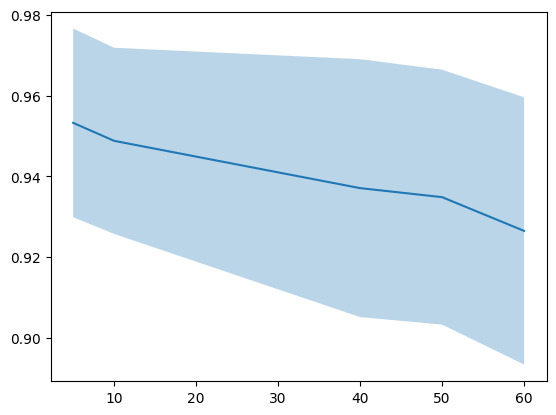

In [31]:
plt.plot(features_ns, [s.mean() for s in results])
plt.fill_between(
    features_ns,
    [np.mean(s) - np.std(s) for s in results],
    [np.mean(s) + np.std(s) for s in results],
    alpha=0.3,
)

#### Зависимость от глубины деревьев

In [35]:
depths = list(range(1, 30))
results = []
for n in depths:
    random_forest_classifier = RandomForestClassifier(max_depth=n, n_jobs=-1)
    result = cross_val_score(random_forest_classifier, x, y, cv=10)
    results.append(result)
    print(n, 'depth:', result.mean())

1 depth: 0.6978367473618869
2 depth: 0.7963376784605835
3 depth: 0.8380571073867162
4 depth: 0.8836964618249535
5 depth: 0.9103879577901927
6 depth: 0.9265270018621974
7 depth: 0.9304220980757293
8 depth: 0.9404469273743017
9 depth: 0.9409962756052141
10 depth: 0.9437864680322781
11 depth: 0.9537988826815642
12 depth: 0.9437957790192426
13 depth: 0.9460086902545003
14 depth: 0.9454469273743016
15 depth: 0.9554717566728739
16 depth: 0.9537988826815642
17 depth: 0.9499130974549969
18 depth: 0.9482433271260087
19 depth: 0.9460117939168218
20 depth: 0.9499193047796399
21 depth: 0.9538019863438857
22 depth: 0.9521353196772191
23 depth: 0.9504655493482309
24 depth: 0.951024208566108
25 depth: 0.9476908752327746
26 depth: 0.9449006828057106
27 depth: 0.950477963997517
28 depth: 0.9499130974549969
29 depth: 0.9460273122284294


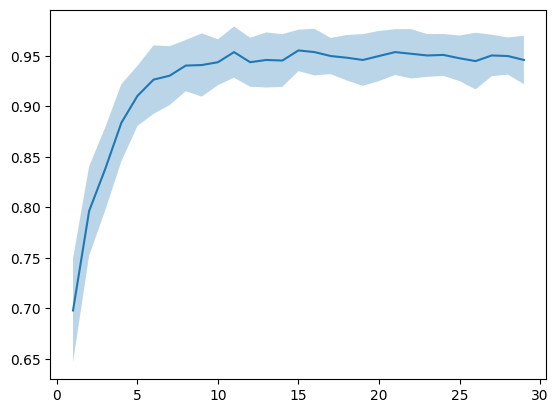

In [36]:
plt.plot(depths, [s.mean() for s in results])
plt.fill_between(
    depths,
    [np.mean(s) - np.std(s) for s in results],
    [np.mean(s) + np.std(s) for s in results],
    alpha=0.3,
)

# Правильные ответы
2. При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев
3. С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.
4. При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.
7. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).